# UNIV*6080 Final Project
# Cameron Jakub

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb # extra tools for data visualization
import pandas as pd # dataframe tools

# Load package which allows us to import R datasts into CoLab
%load_ext rpy2.ipython

# Motivation
We live in a highly digitized world, where we are constantly consuming data in the form of images, videos, webpages, and news feeds. With the abundance and importance of digital data in our modern world, we are faced with the challenge of effectively storing and interpreting very high dimensional data. Examples of high dimensional data include high quality digital images composed of millions of pixels, microarrays of thousands of genes, or spectroscopy data covering a wide range of wavelengths. While high dimensional data of this form is very useful as it has the potential to convey large amounts of information, it is often hard to work with. High dimensional data suffers from a lack of interpretability, being nearly impossible to visualize, and requiring lots of memory and computational power. Luckily, there are ways to manipulate the data in order to make them more friendly to work with.

This report will cover the topic of **dimensionality reduction** using principal component analysis (PCA). In high dimensional data, it is often the case that many dimensions of the data are highly correlated, and that many dimensions offer redundant information (one of the dimensions could be represented as a combination of other dimensions in the data, thus making it unnecessary). We wish to exploit this in order to represent our data in a lower dimensional space, which will be easier to work with and interpret. By "dropping" dimensions which offer redundant information, and "grouping together" dimensions which are correlated, we can create a new representation of our data which lives in a much lower dimensional space, while retaining most of the information in the original data.

This report will be presented in three main sections: First, we present the mathematical theory behind PCA to show how and why it works. After we have established the theory behind PCA, we will go through a simple example step by step, where we code PCA from scratch. Last, we will work with a more complicated higher dimensional example to show how PCA can be used for image compression.



# 1. Derivation of Principal Component Analysis
The following section is based on Chapter 10 of *Mathematics for Machine Learning* by Deisenroth et al., 2020.

Consider an i.i.d. data matrix $X = [\mathbf{x}_1,...,\mathbf{x}_N]$, where each obeservation $\mathbf{x}_i \in \mathbb{R}^D$. Assume that $D$ is a large number, meaning our observations live in a high dimensional space which we cannot easily visualize. Our goal is to find lower dimensional representations of our data points $\mathbf{x}_i$ which live in a lower dimensional space $\mathbb{R}^M$, where $M << N$.

How can we do this? We want to project each point $\mathbf{x}_i \in \mathbb{R}^D$ onto a lower dimensional subspace which lives in $\mathbb{R}^M$, while minimizing loss of information in the process. To do this, we will need a projection matrix $B = [\mathbf{b}_1,...,\mathbf{b}_M] \in \mathbb{R}^{D \times M}$, where column vectors $\mathbf{b}_1$ to $\mathbf{b}_M$ form an orthonormal basis of the lower dimensional space. Let $z_i$ represent the projection of $\mathbf{x}_i$ onto $span\{\mathbf{b}_1,...,\mathbf{b}_M\}$. ie.

$$\mathbf{z}_i = B^T\mathbf{x}_i,\;\;\;i = 1,...,N.$$

In other words, $\mathbf{z}_i$ represents the coordinates of $\mathbf{x}_i$ after it is projected, with respect to the ordered basis $\{\mathbf{b}_1,...,\mathbf{b}_M\}$.

After we perform dimensionality reduction by projecting $\mathbf{x}_i$ onto a lower dimensional space, we will wish to transform this lower-dimensional representation of our data back into the original high-dimensional space. We will represent these transformed points as $\tilde{\mathbf{x}_i} \in \mathbb{R}^D$, and they can be calculated as 

$$ \tilde{\mathbf{x}_i} = B \mathbf{z}_i, \;\;\;i=1,...,N.$$

We see how we can use projections to represent obeservations in a lower dimensional space, and then transform them back to the original space. However, we still do not know how to pick the oprtimal projection. How can we construct $B$ such that minimal information is lost in our dimensionality reduction? What is an appropriate choice of dimension for the subspace we project onto? To answer these questions, we will have to dive further into the mathematics behind PCA.

### Maximum Variance
Our goal is to reduce the dimensionality of our data while minimizing information lost in the process. In order to minimize information lost, the low dimensional representation must capture the maximum amount of variance as possible from the original dataset. We can think of this as trying to find the "directions" in our dataset which have the most variance. We explain this by going through a simple example. Let's create some 2 dimensional datapoints and plot them on the Cartesian plane:

Text(0, 0.5, 'Dimension 2')

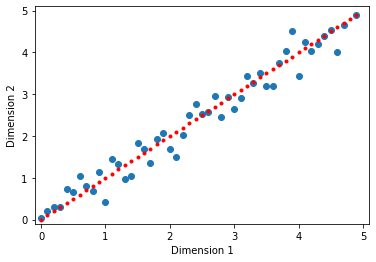

In [ ]:
# Create simple data in a line
x = np.arange(0,5,0.1)
y = x

# Add noise to data
noise = 0.4*np.random.randn(len(x))
y = y + noise

# Plot data
plt.plot(x,x, 'r.')
plt.scatter(x,y)
plt.xlim(-0.1, 5.1)
plt.ylim(-0.1, 5.1)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

Our data in the plot is 2 dimensional ($x$ dimension and $y$ dimension). However, we see that most of the variance in our data doesn't occur along the direction of either axis - it instead occurs along the direction of the red dotted line. In this simple example, the line given by $y=x$ is the **direction of maximum variance**. So, if we want to reduce the dimensionality of our data from 2 to 1, we can project all of our points onto the 1 dimensional subspace given by $y=x$. Doing so, our data will look like this:

Text(0, 0.5, 'Dimension 2')

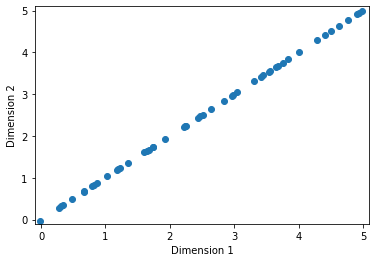

In [ ]:
# Project data onto y=x
x_proj = (x+y)/2.0
y_proj = x_proj

# Plot new lower dimensional data
plt.scatter(x_proj,y_proj)
plt.xlim(-0.1, 5.1)
plt.ylim(-0.1, 5.1)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

We see that our data now lies in a one dimensional subspace, with the basis of the subspace being $\mathcal{B} = (1,1)^T$. This is the main idea behind PCA, except we will begin in a $D$ dimensional space and project down onto an $M$ dimensional space. From this example, it is easy to find the direction of maximum variance visually, but this will not be the case in higher dimensions. How do we find the direction of maximum variance when we can't visualize the data?

Let's start by letting $\mathbf{b}_1 \in \mathbb{R}^D$ be the vector in our high dimensional space for which $span\{\mathbf{b}_1\}$ is the direction of maximum variance. This $\mathbf{b}_1$ is going to be the first column of our projection matrix $B$, and we will assume without loss of generality that $\|\mathbf{b}_1\| =1$. Recall from earlier that $\mathbf{z}_i = B^T\mathbf{x}_i$. Thus, the first coordinate of $\mathbf{z}_i$ is given by $\mathbf{b}_1^T\mathbf{x}_i$. So by picking $\mathbf{b}_1$ to lie in the direction of maximum variance, we are maximizing the variance of the 1st coordinate of each $\mathbf{z}_i$ vector.

Notation: We will let $z_{ij}$ represent the $i^{th}$ coordinate of the vector $\mathbf{z}_j \in \mathbb{R}^M$.

In order to maximize the variance, we must first have an expression of the variance of each coordinate $z_{i \cdot}$, which will correspond to the basis vector $\mathbf{b}_i$. We have that

$$ var(z_{i \cdot}) = \frac{1}{N} \sum_{k=1}^N  z_{ik}^2$$

From our definition of $\mathbf{z}_i$, we have that $z_{ik} = \mathbf{b}_i^T\mathbf{x}_k$. Subbing this in, we get 

$$ \begin{align} 
var(z_{i \cdot}) &= \frac{1}{N} \sum_{k=1}^N  (\mathbf{b}_i^T\mathbf{x}_k)^2 \\
&= \frac{1}{N} \sum_{k=1}^N  (\mathbf{b}_i^T\mathbf{x}_k)(\mathbf{b}_i^T\mathbf{x}_k) \\ 
&= \frac{1}{N} \sum_{k=1}^N  \mathbf{b}_i^T\mathbf{x}_k\mathbf{x}_k^T\mathbf{b}_i \\ 
&= \mathbf{b}_i^T \left( \frac{1}{N} \sum_{k=1}^N \mathbf{x}_k\mathbf{x}_k^T \right)\mathbf{b}_i
\end{align}$$





Note that $\frac{1}{N} \sum_{k=1}^N \mathbf{x}_k\mathbf{x}_k^T$ is the *covariance matrix* of our data, assuming our data is centered. One of the first steps in PCA is centering the data so that $E[\mathbf{x}] = 0$. Note that centering the data does not affect the variance of the data, or the directions of our data which have maximum variance.

 The covariance matrix, which we will denote as $S$, contains the pairwise covariance between any 2 elements of our data vectors $\mathbf{x}_i$. Recall that we made the assumption that $\|\mathbf{b}_i\| = 1$, so we don't have to worry about the size of the $\mathbf{b}_i$ vectors artifically raising the value of $var(z_{i \cdot})$. We want to find the direction of maximum variance, so this turns into a maximization problem! 

To find the direction of maximum variance, we wish to maximize the function $ \mathbf{b}_1^T S\mathbf{b}_1$ under the constraint that $\|\mathbf{b}_i\| =  1$. Using Lagrange multipliers to solve this problem, we end up with the following equation:    

$$S\mathbf{b}_1 = \lambda_1 \mathbf{b}_1 $$

with the constraint that $\|\mathbf{b}_1\| = 1 $. We see that $\mathbf{b}_1$ is an eigenvector of the covariance matrix $S$, and $\lambda_1$ is the corresponding eigenvalue. Subbing this equation into our formula for $var(z_{i \cdot})$, we have 

$$var(z_{i \cdot}) = \mathbf{b}_1^T (S\mathbf{b}_1) = \mathbf{b}_1^T \lambda_1 \mathbf{b}_1 = \lambda_1.$$ 

Therefore, if we want to maximize the variance of $z_{i \cdot}$, we want to choose $\mathbf{b}_1$ to be the eigenvalue of $S$ associated with the largest eigenvalue $\lambda_1$. This eigenvector lies in the direction of maximum variance of our data, and is called the **first principal component**.

### Subsequent Principal Components

We have shown that the first principal component of our data is the eigenvector of the covariance matrix associated with the largest eigenvalue. How do we find the other principal components?

Consider taking our data $X$ and subtracting off the "effect" of the first principal component. We define $\hat{X} = X - \mathbf{b}_1 \mathbf{b}_1^TX = [\hat{\mathbf{x}}_1,..., \hat{\mathbf{x}}_N]$. Following the same process as above, we can calculate a new covariance matrix $\hat{S}$ from the data matrix $\hat{X}$. To find the second principal component, we now have the optimization problem given as

$$ \max var(z_{2 \cdot}) = \mathbf{b}_2^T \hat{S} \mathbf{b}_2 \\ \textrm{subject to} \;\;\;\|\mathbf{b}_2\| = 1$$

Just like we had earlier, the optimal solution of $\mathbf{b}_2$ is going to be the eigenvector associated with the largest eigenvalue of the new covariance matrix $\hat{S}$. It turns out, that this eigenvector is also an eigenvector of our original covariance matrix $S$! In fact, $\mathbf{b}_2$ is the eigenvector of $S$ associated with the second largest eigenvalue of $S$.

Iterating this process, we find that the $m^{th}$ principal component of $X$ is the eigenvector of $S$ corresponding to the $m^{th}$ largest eigenvalue. So in order to find all of the principal components of our data, we simply find all of the eigenvalues of $S$ and their associated eigenvector. If we scale all of the eigenvalues so that they sum to 1, then each eigenvalue is equal to the proportion of variance in the data accounted for by the corresponding principal component.

With the mathematical foundation behind PCA under our belts, we can now work through a simple example:

#2. Cars Data: PCA from Scratch
In this example, we will import a dataset from R (R Foundation for Statistical Computing, 2019), and convert it to a dataframe in Python. We load the dataset *mtcars* from the *datasets* package of R (Henderson and Velleman, 1981). The data describes various features of a number of cars, with the target variable being the fuel efficiency of the car measured in miles per gallon. This dataset has 11 variables and 32 observations, but for our purposes, we will only consider 6 variables in our dataset $X$: number of cylinders, displacement (cu. in.), horsepower, rear axle ratio, weight (1000lbs), and quarter mile time.

In [ ]:
# Load data from R
%%R
carsdata <- mtcars

In [ ]:
# Change data into python dataframe
carsdata = %R carsdata

# Drop unnecessary variables and store in new dataframe
cars = carsdata.drop(["vs", "am", "gear", "carb", "mpg"] ,1)

# Display original datatset
carsdata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6.0,160.0,110.0,3.90,2.620,16.46,0.0,1.0,4.0,4.0
Mazda RX4 Wag,21.0,6.0,160.0,110.0,3.90,2.875,17.02,0.0,1.0,4.0,4.0
Datsun 710,22.8,4.0,108.0,93.0,3.85,2.320,18.61,1.0,1.0,4.0,1.0
Hornet 4 Drive,21.4,6.0,258.0,110.0,3.08,3.215,19.44,1.0,0.0,3.0,1.0
Hornet Sportabout,18.7,8.0,360.0,175.0,3.15,3.440,17.02,0.0,0.0,3.0,2.0
Valiant,18.1,6.0,225.0,105.0,2.76,3.460,20.22,1.0,0.0,3.0,1.0
Duster 360,14.3,8.0,360.0,245.0,3.21,3.570,15.84,0.0,0.0,3.0,4.0
Merc 240D,24.4,4.0,146.7,62.0,3.69,3.190,20.00,1.0,0.0,4.0,2.0
Merc 230,22.8,4.0,140.8,95.0,3.92,3.150,22.90,1.0,0.0,4.0,2.0
Merc 280,19.2,6.0,167.6,123.0,3.92,3.440,18.30,1.0,0.0,4.0,4.0


Next, we need to center the data. For PCA, it is typical to normalize the data first to have both a mean of 0 *and* a standard deviation of 1. In this example, we will be working with the normalized data. The *StandardScaler* function in the *scikit-learn* library (Pedregosa et al., 2011) allows for simple normalization of the data:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data to have mean 0 and standard deviation 1
cars = StandardScaler().fit_transform(cars)

# Check that all of the columns of our data now have mean 0
for i in range(len(cars.T)):
  print(round(cars[:,i].mean(),8))

0.0
0.0
0.0
-0.0
-0.0
-0.0


Now, we need to find the covariance matrix of the data. Using the formula $S = \frac{1}{N} \sum_{k=1}^N \mathbf{x}_k\mathbf{x}_k^T$, we obtain:

In [ ]:
# Obtain dimensions of our data
N = len(cars)
D = len(cars.T)

# Initialize covariance matrix of zeros
covar = np.zeros((D,D))

# Calculate sum of outer products 
for i in range(N):
  covar = covar + np.outer(cars[i,:], cars[i,:])
  
# Scale matrix by 1/N
covmatrix = covar/N

# Print matrix
np.set_printoptions(precision=4, suppress = True)
covmatrix

array([[ 1.    ,  0.902 ,  0.8324, -0.6999,  0.7825, -0.5912],
       [ 0.902 ,  1.    ,  0.7909, -0.7102,  0.888 , -0.4337],
       [ 0.8324,  0.7909,  1.    , -0.4488,  0.6587, -0.7082],
       [-0.6999, -0.7102, -0.4488,  1.    , -0.7124,  0.0912],
       [ 0.7825,  0.888 ,  0.6587, -0.7124,  1.    , -0.1747],
       [-0.5912, -0.4337, -0.7082,  0.0912, -0.1747,  1.    ]])

Note that we could also calculate the covariance matrix of the data using NumPy's built in function *numpy.cov()* (Harris et al. 2020):

In [ ]:
covmatrix = np.cov(cars.T)
covmatrix 

array([[ 1.0323,  0.9311,  0.8593, -0.7225,  0.8077, -0.6103],
       [ 0.9311,  1.0323,  0.8165, -0.7331,  0.9166, -0.4477],
       [ 0.8593,  0.8165,  1.0323, -0.4632,  0.68  , -0.7311],
       [-0.7225, -0.7331, -0.4632,  1.0323, -0.7354,  0.0941],
       [ 0.8077,  0.9166,  0.68  , -0.7354,  1.0323, -0.1804],
       [-0.6103, -0.4477, -0.7311,  0.0941, -0.1804,  1.0323]])

We see that this matrix isn't exactly the same as the matrix we calculated earlier. The reason is that the *numpy.cov* function uses the formula $\frac{1}{N-1} \sum_{k=1}^N \mathbf{x}_k\mathbf{x}_k^T$, so the sum of the outer product is divided by $N-1$ rather than $N$. If we were to divide by $N-1$ in our previous calculation, we see we would get the same result:

In [ ]:
covmatrix = covar/(N-1)
covmatrix

array([[ 1.0323,  0.9311,  0.8593, -0.7225,  0.8077, -0.6103],
       [ 0.9311,  1.0323,  0.8165, -0.7331,  0.9166, -0.4477],
       [ 0.8593,  0.8165,  1.0323, -0.4632,  0.68  , -0.7311],
       [-0.7225, -0.7331, -0.4632,  1.0323, -0.7354,  0.0941],
       [ 0.8077,  0.9166,  0.68  , -0.7354,  1.0323, -0.1804],
       [-0.6103, -0.4477, -0.7311,  0.0941, -0.1804,  1.0323]])

The reason they use $N-1$ rather than $N$ is because using $N-1$ produces an unbiased estimator. Recall that the principal components of our data are simply the eigenvectors of our covariance matrix scaled to be norm 1. Scaling our matrix by a constant will not affect the eigenvalues of our matrix, so whether the covariance matrix is calculated using $N-1$ or $N$ will not affect our analysis.

We now calculate the eigenvectors along with the eigenvalues, in order to see how much variance of our data is explained by each principal component.

In [ ]:
# Calculate eigenvectors and eigenvalues
eigval, eigvec = np.linalg.eig(covmatrix)

# View the eigenvectors 
print("Eigenvectors (column-wise):")
print(eigvec)

# View the eigenvalues
print("\n Eigenvalues:")
print(eigval)

Eigenvectors (column-wise):
[[ 0.4677  0.0547 -0.1407  0.286  -0.4482  0.6898]
 [ 0.4647 -0.1075  0.2145  0.3308  0.7784  0.1058]
 [ 0.4279  0.319   0.2456 -0.8018  0.0483  0.0984]
 [-0.3615  0.4726  0.7315  0.2431 -0.0539  0.2211]
 [ 0.4205 -0.34    0.4961  0.1536 -0.4318 -0.5013]
 [-0.2733 -0.7381  0.3043 -0.2886  0.0388  0.4507]]

 Eigenvalues:
[4.3847 1.1849 0.3411 0.1359 0.0667 0.0803]


The *numpy.linalg.eig* function will always give us unit length eigenvectors. But to be sure, we can calculate the norm of each eigenvector to ensure they are all norm 1:

In [ ]:
for i in range(len(eigvec[0])):
  # Print the Euclidean norm of each eigenvector
  print(np.linalg.norm(eigvec[:,0]))

1.0
1.0
1.0
1.0
1.0
1.0


We can also check to make sure that the eigenvalues of our covariance matrix are all linearly independent:

In [ ]:
# Compute column rank of eigenvector matrix
np.linalg.matrix_rank(eigvec)

6

We see that the columns of eigvec are linearly independent, as the matrix is full rank.

Let's go back to the eigenvalues. Remember that the size of each eigenvalue is related to how much variance of the data is explained by its corresponding eigenvector. To find exactly how much variance is explained by each eigenvector/principal component, we can scale the eigenvalues so they sum to 1:

In [ ]:
# Scale the eigenvalues to sum to 1 to compute how much variance is explained by each
eigsum = eigval.sum()
eigval_scaled = eigval/eigsum
print(eigval_scaled)

[0.7079 0.1913 0.0551 0.0219 0.0108 0.013 ]


We now will order the eigenvalues from largest to smallest, and create a plot which represents the percent of variance accounted for when we include $k$ principal components in our dimensionality reduction.

Text(0, 0.5, 'Percentage of Variance Exaplained')

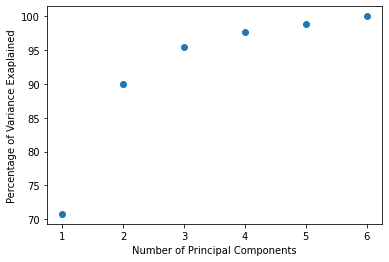

In [ ]:
# Sort eigenvalues largest to smallest
eig_sorted = -np.sort(-eigval_scaled)

# Create cumulative vector of percent variance explained
eig_sum = np.cumsum(eig_sorted)*100

# Plot the data
plt.scatter(np.arange(1,7), eig_sum)
plt.xlabel("Number of Principal Components")
plt.ylabel("Percentage of Variance Exaplained")

We see that using the eigenvectors associated with the 3 largest eigenvectors in the data, we can explain roughly $70.79 + 19.13 + 5.51 = 95.43\%$ of the variance in our data! If we work with the first 3 principal components, we can now work in 3 dimensions rather than 6, without losing much information. Visualizing data in 6 dimensions is practically impossible, but visualizing data in 3 dimensions is straightforward!

For the purpose of simple visualization, we will project our data onto a 2 dimensional subspace using the first two principal components. This will account for $89.92\%$ of the variance in our data. The columns of the array  *eigvec* are the basis vectors $\{ \mathbf{b}_1,...\mathbf{b}_6 \}$, and thus the *eigvec* array is our projection matrix $B$. However, our $B$ matrix is currently has a rank of 6, meaning projecting onto  $span\{ \mathbf{b}_1,...\mathbf{b}_6 \}$ will not reduce the dimensionality of this problem. We want to work in a 2 dimensional space, so we will remove all columns of the $B$ matrix except for the first two.

In [ ]:
# Remove all columns except the first 2
B = eigvec[:,[0,1]]
print(B)

[[ 0.4677  0.0547]
 [ 0.4647 -0.1075]
 [ 0.4279  0.319 ]
 [-0.3615  0.4726]
 [ 0.4205 -0.34  ]
 [-0.2733 -0.7381]]


Now we compute the lower-dimensional, projected data as $\mathbf{z}_i = B^T\mathbf{x}_i$.

In [ ]:
# Compute matrix vector product B^T*x
cars_proj = np.dot(B.T,cars.T)

# Print the dimensions of our new data
np.shape(cars_proj.T)

(32, 2)

The array *cars_proj* is now an array of 2 dimensional observations of the form $[\mathbf{z}_1,..., \mathbf{z}_{32}]$, where $\mathbf{z}_i \in \mathbb{R}^2$. Note that we purposely left out the variable "mpg" (miles per gallon) in our principal component analysis. Now that we have performed dimensionality reduction to represent our data in a 2 dimensional space, we can visualize how the variables in our dataset relate to the fuel efficiency of the cars in our data.

Let's plot this: Our $x$ and $y$ axes will represent the directions of principal components 1 and 2, respectively, and the colour of each point will describe the fuel efficiency for each observation.

Text(0, 0.5, 'Principal Component 2')

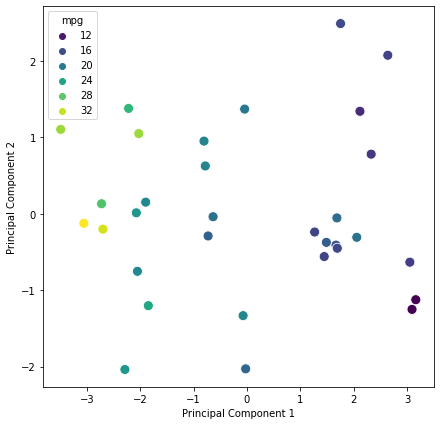

In [ ]:
# Plot mpg data with x axis being PC1 and y axis being PC2
plt.figure(figsize=(7,7))
sb.scatterplot(x = cars_proj[0,:], y = cars_proj[1,:], hue = carsdata["mpg"], s = 100, palette = "viridis")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

We now have a visualization of our data in 2 dimensions. Note that we see more variance in *mpg* in the $x$ direction compared to the $y$ direction. This intiutively makes sense, since the $x$ axis is the first principal component, which is the direction of maximum variance in our data! In fact, the first principal component accounts for $70.79\%$ of the variance in our data.

We can reconstruct the lower-dimensional data in the original 6 dimensional space by calculating $ \tilde{\mathbf{x}_i} = B \mathbf{z}_i$:


In [ ]:
# Compute matrix-vector product B*z
cars_reconstructed = np.dot(B, cars_proj)

# Print the first 5 observations in our transformed dataset
cars_reconstructed.T[np.arange(5),:]

array([[-0.3248, -0.4762, -0.0418,  0.7397, -0.6615, -0.4805],
       [-0.3312, -0.43  , -0.1351,  0.5773, -0.5407, -0.2472],
       [-0.9695, -0.965 , -0.8839,  0.7551, -0.8761,  0.5585],
       [-0.1067,  0.1099, -0.4564, -0.6045,  0.4234,  1.0044],
       [ 0.786 ,  0.7899,  0.7042, -0.6361,  0.7284, -0.42  ]])

And we are done! We have effectively transformed our 6 dimensional data into a 2 dimensional representation, while preserving $89.92 \%$ of the variance from the original dataset. In other words, we have *compressed* our data so that it takes up less memory. The following example will demonstrate how PCA can be used for image compression tasks.

# 3. Image Compression: A Higher Dimensional Example 
The previous example was relatively simple, involving only 6 dimensional data. What if we tried a much higher dimensional example? One common use of PCA is for image compression, which we will briefly demonstrate in this example. We start by loading our data, which is a set of images of faces, with each image being $50 \times 37$ pixels. The images are of well-known people's faces, including George Bush and Hugo Chaves. There are 12 people included in this dataset, with at least 50 pictures each, totalling to 1560 pictures. Let's load the data:

**Note: it may take ~1 minute to run this next cell, as we are loading a large dataset**

In [ ]:
from PIL import Image

# Load data (may be slow)
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

The data consists of: a 3 dimensional array *people.images* which contains 1560 matrices of the pixel values for each image, *people.target* which contains a number assigning each image to the corresponding person, as well as *people.target_names*, which is an array of strings containing the names of each person included in the dataset. Let's take a quick look at the data:

First matrix in our dataset:
[[ 91.          97.666664   101.666664   ...   3.           3.
    2.        ]
 [100.333336   106.         110.333336   ...   3.6666667    3.
    3.        ]
 [112.666664   118.333336   121.666664   ...   4.6666665    2.
    1.6666666 ]
 ...
 [ 96.666664    94.666664    69.         ...   0.6666667    1.
    0.        ]
 [ 83.          98.666664    85.         ...   1.           0.6666667
    0.        ]
 [ 75.          88.333336    98.666664   ...   1.3333334    1.
    0.33333334]]

 
 Corresponding image in our dataset:
Name: George W Bush


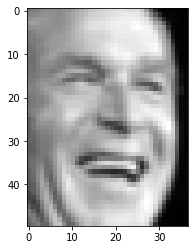

In [ ]:
# Set the image number you would like to view (k = 0,...,1559)
k=47

if k>=0 and k<=1559:

  # Print out the kth image, represented as a matrix of values from 0 to 255
  print("First matrix in our dataset:")
  print(people.images[k])

  # Print out the actual image 
  print("\n \n Corresponding image in our dataset:")
  plt.gray()
  plt.imshow(people.images[k])

  # Print out the name of the person photographed
  print("Name:", people.target_names[people.target[k]])

else:
  print("Invalid choice of parameter k")


As we can see, these images are not very high quality by today's standards. Yet, they still live in a high dimensional space. Since the images are 50 by 37 pixels, each image is 1850-dimensional! So storing each image requires storing 1850 numbers corresponding to the brightness of each pixel. That means to store our entire dataset, we need to store 2886000 numbers in memory! This is very inefficient, so we turn to PCA.

For efficiency and demonstration purposes, we will perform PCA using the *PCA* function in the *scikit-learn.decomposition* library (Pedregosa et al., 2011), rather than doing it from scratch. This gives us a more concise method for doing PCA now that we understand how to code it. We begin by reformatting our image data from a 3 dimensional array to a 2 dimensional array to make it compatible with the *PCA* function we will be using:

In [ ]:
# Retrieve the dimensions of our dataset
n_obs,h,w = np.shape(people.images)

# Initialize new 2d array to store data, as the PCA function only works with
# 2 dimensional arrays
people_vec = np.zeros((n_obs, h*w))

# Reformat data to be a collection of vectors
for i in range(n_obs):
  people_vec[i] = people.images[i].reshape(-1)

# We now have a 1560 x 1850 array
np.shape(people_vec)

(1560, 1850)

Next, we perform PCA on our data with 100 components:

In [ ]:
from sklearn.decomposition import PCA

# Fit a PCA with 100 components
pca = PCA(n_components=100)
pca.fit(people_vec)

# Print the principal components (eigenvalues)
print(pca.components_)


[[-0.00650595 -0.00801861 -0.01062142 ... -0.01184175 -0.01020916
  -0.00865475]
 [ 0.02155267  0.0205743   0.02251656 ... -0.04846996 -0.04678385
  -0.04477429]
 [ 0.03278256  0.03180615  0.03065747 ...  0.05173572  0.04628543
   0.04114387]
 ...
 [ 0.00552571  0.00144752  0.01582947 ...  0.01532945  0.02325805
   0.02963477]
 [ 0.10142715  0.07589661  0.00823062 ...  0.05043401  0.05757216
   0.02418104]
 [ 0.00775167 -0.00948408 -0.02189619 ... -0.01193264 -0.01144234
   0.01517496]]


We now have calculated the first 100 principal components of our data. These principal components (or eigenvalues) are in the same dimensional space as our images, so we can actually plot them as images! Let's look at the first 10 principal components of our data, which are the most "important" components in terms of accounting for variance in our data:

% variance explained by the first 10 components:
[0.21804204 0.14007658 0.07258941 0.05855634 0.04792147 0.02787142
 0.02319646 0.019436   0.01901012 0.01782031]


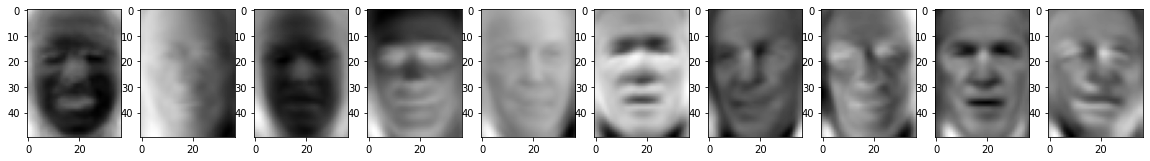

In [ ]:
# Print the variance explained by each principal component
print("% variance explained by the first 10 components:")
print(pca.explained_variance_ratio_[range(0,10)])

# Set figure size
plt.figure(figsize=(20,10))

for i in range(0,10):
    plt.subplot(1, 10, i+1)

    # Plot each eigenvector/principal component
    plt.gray()
    plt.imshow(pca.components_[i].reshape(50,37))

Visualization of these eigenvectors reveals human like images! Since our data consisted entirely of faces, the principal components are trying to pick up on the features which vary most between faces in our dataset. When we display these features, faces emerge!

Now let's take a look at principal components 91-100, which account for significantly less of the variance compared to the first 10:

% variance explained by principal components 91-100:
[0.00094015 0.00093349 0.00091514 0.00089831 0.0008878  0.00087215
 0.00085082 0.00083974 0.00081355 0.00080316]


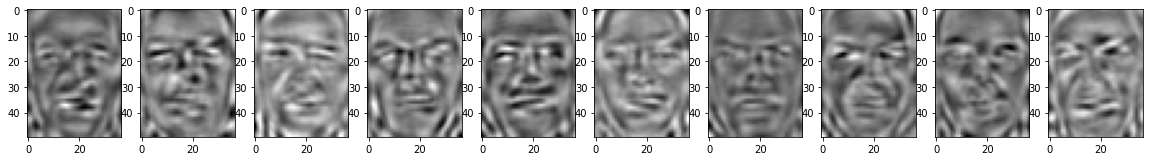

In [ ]:
# Print the variance explained by each principal component
print("% variance explained by principal components 91-100:")
print(pca.explained_variance_ratio_[range(90,100)])

# Set figure size
plt.figure(figsize=(20,10))

for i in range(90,100):
    plt.subplot(1, 10, i-89)

    # Plot each eigenvector/principal component
    plt.gray()
    plt.imshow(pca.components_[i].reshape(50,37))

Though we can still recognize faces in these images, we see we have much sharper and more complex patterns in these principal components. This makes sense intuitively - the most variance seen between faces is going to be from dramatic differences in lighting, shading, and skin tone. This is seen in the softer patterns of the first 10 components, where the images resemble blurry facial shading patterns.

On the other end, we would expect that components which represent finer details on the human face would account for less of the variance of the data. This is consistent with what is displayed - components corresponding to smaller eigenvalues typically show patterns of finer detail when visualized in this way.

Now that we have some understanding of what the principal components look like, let's use them to construct an image in a lower dimensional space! We will use the 100 principal components we calculated to construct this image:

Name: John Ashcroft


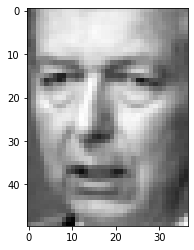

In [ ]:
# Print out the image 
plt.gray()
plt.imshow(people.images[50])

# Print out the name of the person photographed
print("Name:", people.target_names[people.target[50]])

To do this, we transform the data into lower dimensional space ($\mathbf{z}_i = B^T \mathbf{x}_i$) and then transform it back into the 1560-dimensional space so we can visualize it as an image ($ \tilde{ \mathbf{x}_i} = B \mathbf{z}_i$).

Name: John Ashcroft


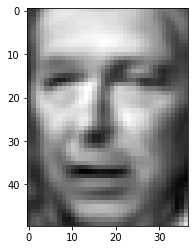

In [ ]:
# Transform down to 100-dimensional space
z_vec = pca.transform(people_vec)

# Transform back to original space
people_trafo = pca.inverse_transform(z_vec)

# Print out the image 
plt.gray()
plt.imshow(people_trafo[50].reshape((50,37)))

# Print out the name of the person photographed
print("Name:", people.target_names[people.target[50]])

We now have an image which is an approximation of the original image, but lives in a much lower dimensional space. By including more principal components in the approximation, we can obtain an approximation which requires slightly more memory than this one, but more closely represents the original image. By including less principal components, we can obtain a less accurate approximation at the benefit of saving memory. It is up to the user to decide whether they would like to prioritize memory savings or accuracy of approximations.

To store the original dataset, we need to store every pixel value of every image, which we calculated to be $2886000$ numbers. Now that we have our projection matrix $B \in \mathbb{R}^{1850 \times 100}$, we only need to store the eigenvectors which make up the columns of $B$, and then for each image, we just store the coordinates of that image with respect to the ordered basis $\mathcal{B} = \{\mathbf{b}_1,...,\mathbf{b}_{100}\}$ (100 numbers each). In total, we need to store $(1560 \times 100) + (1850 \times 100) = 341000$ numbers. So using this approximation with PCA uses $11.8 \%$ of the memory it would take to store the images directly!

### Interactive:    
Change the value of $j$ in the following code to see different images in our dataset and their approximation using PCA

Name: George W Bush


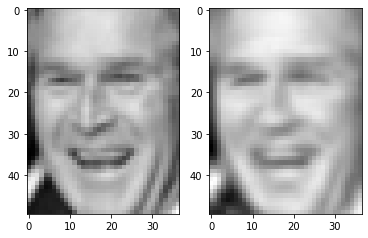

In [ ]:
# change value of j (j=0,...,1559)
j=140

if j>=0 and j<=1559:

  # Print out the name of the person photographed
  print("Name:", people.target_names[people.target[j]])

  # Print Images side by side
  for i in range(0,2):
    plt.subplot(1, 2, i+1)
    plt.gray()
    if i==0:
      plt.imshow(people.images[j]) # Print original
    else:
      plt.imshow(people_trafo[j].reshape((50,37))) #Print approximation
      
else:
  print("Invalid choice of parameter j")

In all, PCA is a very powerful, accessible, and conceptually simple tool for dimensionality reduction. 

# Bibliography

Deisenroth, M. P., Faisal, A. A., Ong, C. S. (2020). Mathematics for machine learning (pp. 317-347). Cambridge University Press.

Gautier, L. (2019). rpy2 - R in Python. URL https://github.com/rpy2/rpy2

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. (2020). Array programming with NumPy. *Nature*, **585**, 357–362.


Henderson, H. V., & Velleman, P. F. (1981). Building multiple regression models interactively. *Biometrics*, **37**, 391–411. 

Hunter, J.D. (2007). Matplotlib: a 2D graphics environment, *Computing in Science & Engineering*, **9**(3), 90-95.

McKinney, W. (2010). Data structures for statistical computing in Python. *Proceedings of the 9th Python in Science Conference*, **445**, 56-61.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, E. (2011). Scikit-learn: Machine learning in Python, Journal of Machine Learning Research, **12**, 2825-2830.

R Core Team (2019). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.

Reback, J., McKinney, W. jbrockmendel, Van den Bossche, J., Augspurger, T., PhillipCloud, gfyoung, Sinhrks, Klein, A., Roeschke, M., Hawkins, S., Tratner, J., She, C., Ayd, W.,   Petersen, T., Garcia, M., Schendel, J., Hayden, A., MomIsBestFriend, Jancauskas, V., Battiston, P., Seabold, S., chris b1, Vetinari, H., Hoyer, S., Overmeire, W.,  alimcmaster1,  Dong, K.,  ChristopherWhelan, Mehyar, M. (2020). Pandas  1.0.3.   URL https://doi.org/10.5281/zenodo.3715232.

Umesh, P. (2012). Image Processing in Python. *CSI Communications*, **23**.

Waskom, M. L. (2021). Seaborn: statistical data visualization. *Journal of Open Source Software*. **6**(60), 3021.